# Harris Corner Detection

In this notebook the rotation of an image will be estimated by matching ponits using Harris Corner Detection.

The Harris Corner Detection uses the sobel vertical and horizontal filter. We then create a new image of the form $I_x^2, I_x \times I_y, I_y^2$. This image is then blurred with a gaussian convolution and then the corner response is then output.

Consider that at a corner at $x$ and $y$, we expect $I_x^2$ and $I_y^2$ to be high. At nearby edges, we will see either a high $I_x^2$ or a high $I_y^2$ but not a high $I_x \times I_y$. The corner point its self will have a low reponse on its own.

Two neighbouring points will have a high $I_x^2$ with low $I_y \times I_x$ and a high $I_y^2$ with low $I_y \times I_x$. Thus by taking the average we sum the high $\sum_w{I_x^2}$ and $\sum_w{I_y^2}$ and a low $\sum_w{I_y \times I_x}$.

If just $\sum_w{I_y^2}$ or just $\sum_w{I_x^2}$ were high then it would be just an edge. We want both $\sum_w{I_y^2}$ and $\sum_w{I_x^2}$ to be high and of a similiar magnitude by using some metric such as...

$\frac{\sum_w{I_y^2} \sum_w{I_x^2} - (\sum_w{I_y \times I_x})^2}{\sum_w{I_y^2} + \sum_w{I_x^2}}$.

In [1]:
# export
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import ConnectionPatch
from dataclasses import dataclass
from matplotlib.patches import Circle

In [2]:
import pdb
from Export.nb_HistogramEqualisation import compareTwoImages

In [3]:
# export
from Export.nb_Convolutions1D import oneDimConvolution, gaussianConv, derivative
from Export.nb_ConvertToHSV import convertToGrey, showEachChannel
from Export.nb_PixelManipulation import getChannels, iterateImage, timeSomething
from Export.nb_HistogramEqualisation import compareTwoImages

## Setting up the input images

In [4]:
frog_img_pil = Image.open('Images/dat_boi.jpg')

In [5]:
rotated_frog_pil = frog_img_pil.rotate(120, fillcolor = (255, 255, 255))

In [6]:
frog_img = np.array(frog_img_pil)
rotated_frog = np.array(rotated_frog_pil)

In [7]:
frog_img = cv2.cvtColor(frog_img, cv2.COLOR_RGB2BGR)
rotated_frog = cv2.cvtColor(rotated_frog, cv2.COLOR_RGB2BGR)

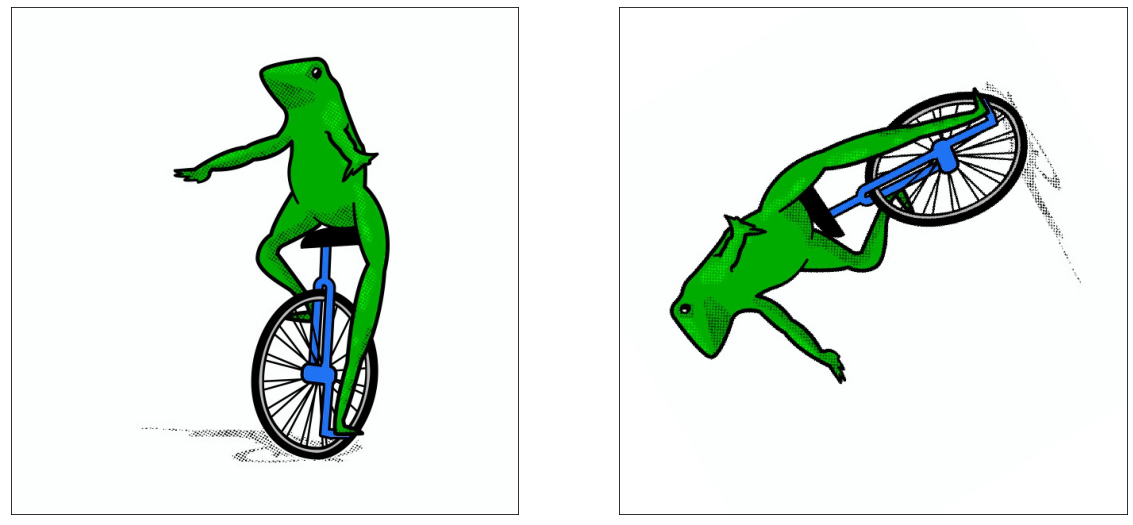

In [8]:
compareTwoImages(frog_img, rotated_frog);

In [9]:
grey_frog_img = frog_img.copy()
grey_rotated_frog = rotated_frog.copy()
grey_frog_img = convertToGrey(grey_frog_img)
grey_rotated_frog = convertToGrey(grey_rotated_frog)

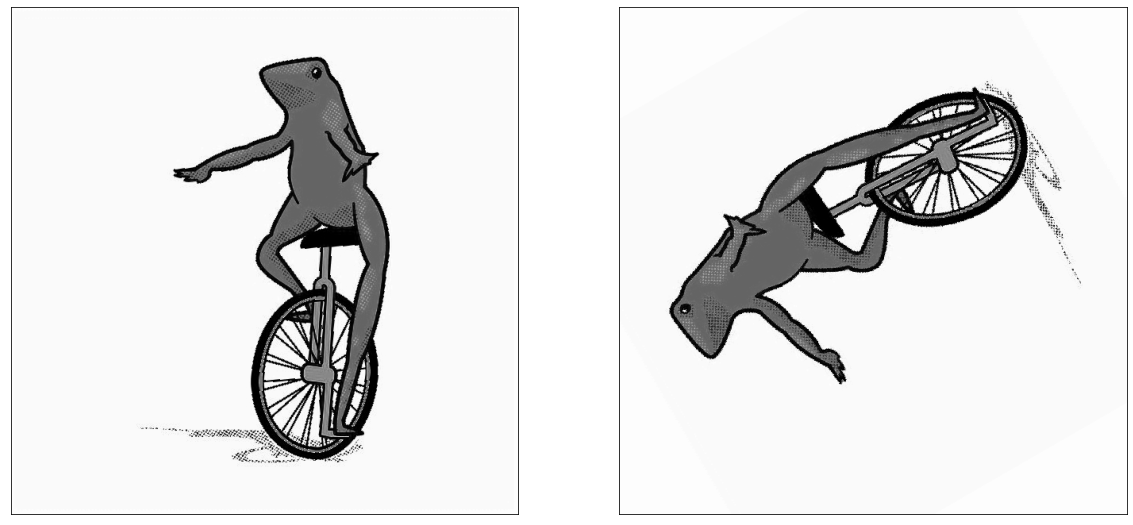

In [10]:
compareTwoImages(grey_frog_img, grey_rotated_frog, cmap = 'gray');

In [11]:
grey_copy = grey_frog_img.copy()
rota_copy = grey_rotated_frog.copy()

## Harris Corner Detection Pre-processing

Convert a greyscale image into 3 channel image containing each of the following quanitities...  $I_x^2$, $I_y^2$, $I_y \times I_x$.

In [12]:
# export
def computeGradientPolyImage(img: np.array, kernel_size: int):
    _, height, width, channels, _ = getChannels(img)
    if channels != 1 : print('Incorrect input size'); return
    hori_deriv = oneDimConvolution(img.copy(), derivative(kernel_size), True)
    vert_deriv = oneDimConvolution(img.copy(), derivative(kernel_size), False)
    output_img = np.dstack((hori_deriv, vert_deriv, np.zeros((height, width), dtype = np.float32)))
    i, j, k = 0, 0, 0
    for px in np.nditer(output_img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            current_x = px
        elif k == 1:
            current_y = px
        else:
            px[...] = current_x * current_y
            current_x[...] **= 2
            current_y[...] **= 2
        i, j, k = iterateImage(i, j, k, 3, width)
    return output_img

In [13]:
grad_frog = computeGradientPolyImage(grey_frog_img, 7)

This effect creates a disco frog. Now each channel of the image can be blurred.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


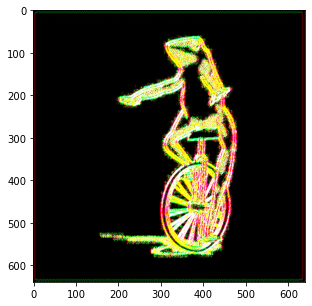

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(grad_frog/255);

## Gaussian Blur Each Channel

In order to take a window, we just take a guassian blur or each channel.

In [15]:
conv_y, conv_x = gaussianConv(5, 5)
grad_frog = oneDimConvolution(grad_frog, conv_y, False)
grad_frog = oneDimConvolution(grad_frog, conv_x, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


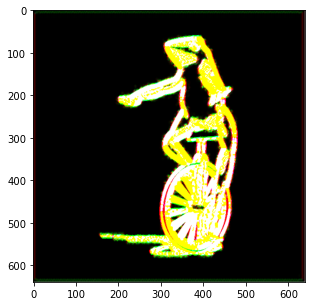

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(grad_frog/255);

## Evaluate Corner Potential of 'Gradient Poly' Image

Define a function that takes in $I_x^2$, $I_y^2$, $I_y \times I_x$  and outputs a measure of 'cornerness'. The function also gives a magitude and an angle.

In [17]:
# export
def determinantOverTrace(Ix2: float, Iy2: float, IyIx: float):
    trace = Ix2 + Iy2
    det = Ix2*Iy2 - IyIx**2
    angle = Ix2 - Iy2
    mag = np.sqrt(trace)
    if angle == 0:
        np.pi/2 * np.sign(IyIx)
    else:
        angle = np.arctan(2*IyIx/angle)/2
    if trace == 0: return 0, 0, 0
    return (mag, angle, det/trace)

In [18]:
# export
def updateMinMaxChannels(output_vector: tuple, max_channels: dict, min_channels: dict):
    for channel in max_channels.keys():
        if output_vector[channel] > max_channels[channel]:
            max_channels[channel] = output_vector[channel]
        if output_vector[channel] < min_channels[channel]:
            min_channels[channel] = output_vector[channel]
            
def divideByMaxChannels(img: np.array, max_channels: dict, min_channels: dict):
    for channel, max_channel in max_channels.items():
        min_channel = min_channels[channel]
        img[:, :, channel] -= min_channel
        max_channel -= min_channel
        if max_channel > 0: img[:, :, channel] /= max_channel

def computeCornerMeasure(img: np.array, cornerMeasure):
    _, _, width, channels, _ = getChannels(img)
    if channels != 3 : print('Incorrect numer of input channels'); return
    i, j, k = 0, 0, 0
    max_channels = {0:0,1:0,2:0}
    min_channels = {0:0,1:0,2:0}
    for px in np.nditer(img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            current_x = px
        elif k == 1:
            current_y = px
        else:
            output_vector = cornerMeasure(current_x, current_y, px)
            current_x[...] = output_vector[0] 
            current_y[...] = output_vector[1]
            px[...] = output_vector[2]
            updateMinMaxChannels(output_vector, max_channels, min_channels)
        i, j, k = iterateImage(i, j, k, 3, width)
    divideByMaxChannels(img, max_channels, min_channels)
    return img

In [19]:
harris_frog = computeCornerMeasure(grad_frog, determinantOverTrace)

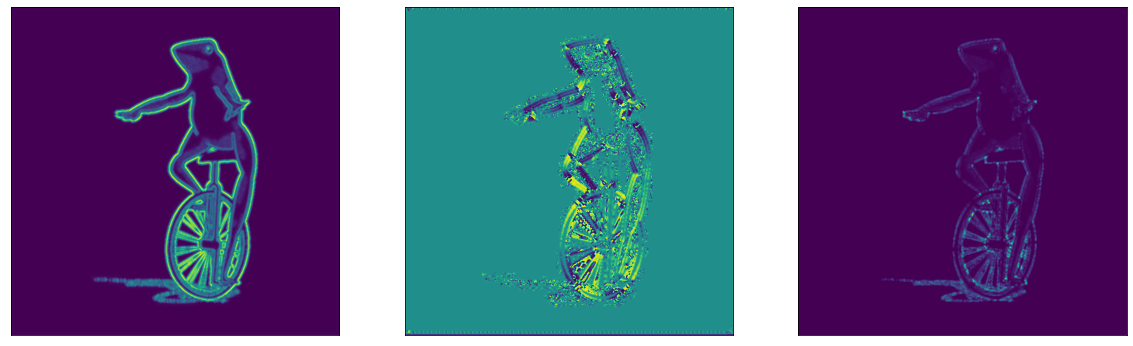

In [20]:
showEachChannel(harris_frog, cmap = 'viridis')

## Converting the Two Images

Now all the above functions are put into a single function that turns a greyscale image into a harris corner output. There are three channels for the corner output: the magnitude, the angle between eigen vectors and the energy function used to a find a threshold for corners.

In [21]:
# export
def harrisCornerImage(img : np.array, derivative_size: int, blur_size: int, energyFunction):
    grad_frog = computeGradientPolyImage(img, derivative_size)
    blur_y, blur_x = gaussianConv(blur_size, blur_size)
    grad_frog = oneDimConvolution(grad_frog, blur_y, False)
    grad_frog = oneDimConvolution(grad_frog, blur_x, True)    
    return computeCornerMeasure(grad_frog, energyFunction)

In [22]:
initial_harris = harrisCornerImage(grey_frog_img, 7, 5, determinantOverTrace)

In [23]:
assert(np.linalg.norm(initial_harris - harris_frog) < 1e-7)

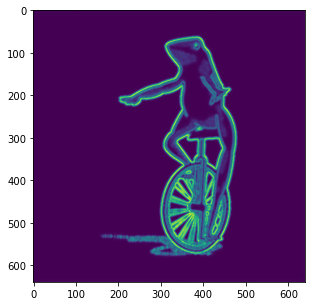

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(initial_harris[:,:,0]);

In [25]:
rotated_harris = harrisCornerImage(grey_rotated_frog, 7, 5, determinantOverTrace)

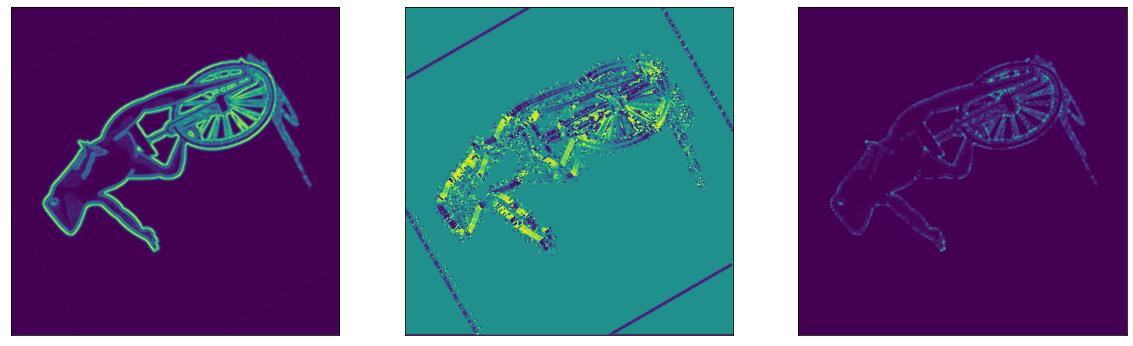

In [26]:
showEachChannel(rotated_harris, cmap = 'viridis')

## Drawing on Two Images Given Matches With Different Strengths

Matches will be stored in a dictionary where two points are stored along with their matching affinity.

In [27]:
# export
@dataclass
class HarrisMatch: 
    coordinateA: np.array = np.array([0,0], dtype = np.float32)
    coordinateB: np.array = np.array([0,0], dtype = np.float32)
    affinity:float = 0.
    
    def drawPointToPoint(self, target_axis: plt.axis, init_axis: plt.axis, px1: np.array, px2: np.array, **kwargs):
        target_axis.plot([px1[0]],[px1[1]], 'rx', markersize=10)
        con = ConnectionPatch(xyA=px1, xyB=px2, coordsA="data", coordsB="data",
                        axesA=target_axis, axesB=init_axis, **kwargs)
        target_axis.add_artist(con)
    
    def drawOnAxes(self, ax1: plt.axis, ax2: plt.axis, **kwargs):
        self.drawPointToPoint(ax1, ax2, self.coordinateA, self.coordinateB, **kwargs)
        self.drawPointToPoint(ax2, ax1, self.coordinateB, self.coordinateA, **kwargs)

In [28]:
test_matches = [
    HarrisMatch((300, 320), (340, 200), 20),
    HarrisMatch((320, 300), (320, 200), 50),
    HarrisMatch((200, 220), (350, 120), 255)
]

In [29]:
# export
def drawArrowsOnImages(image1: np.array, image2: np.array, matches: list, cmap_image: str, cmap_match: str, **kwargs):
    cmap = matplotlib.cm.ScalarMappable(
      norm = matplotlib.colors.Normalize(0, 255), 
      cmap = cmap_match
    )
    cmap.set_array([])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    ax1, ax2, fig = compareTwoImages(image1, image2, cmap = cmap_image)
    for match in matches:
        kwargs['color'] = cmap.to_rgba(match.affinity)[:3]
        match.drawOnAxes(ax1, ax2, **kwargs)
    fig.subplots_adjust(bottom=0.1)
    plt.colorbar(cmap, orientation='horizontal', cax = fig.add_axes([0.2, 0.05, 0.6, 0.03]));
    plt.gca().set_xlabel('Match Affinity', fontsize=16);

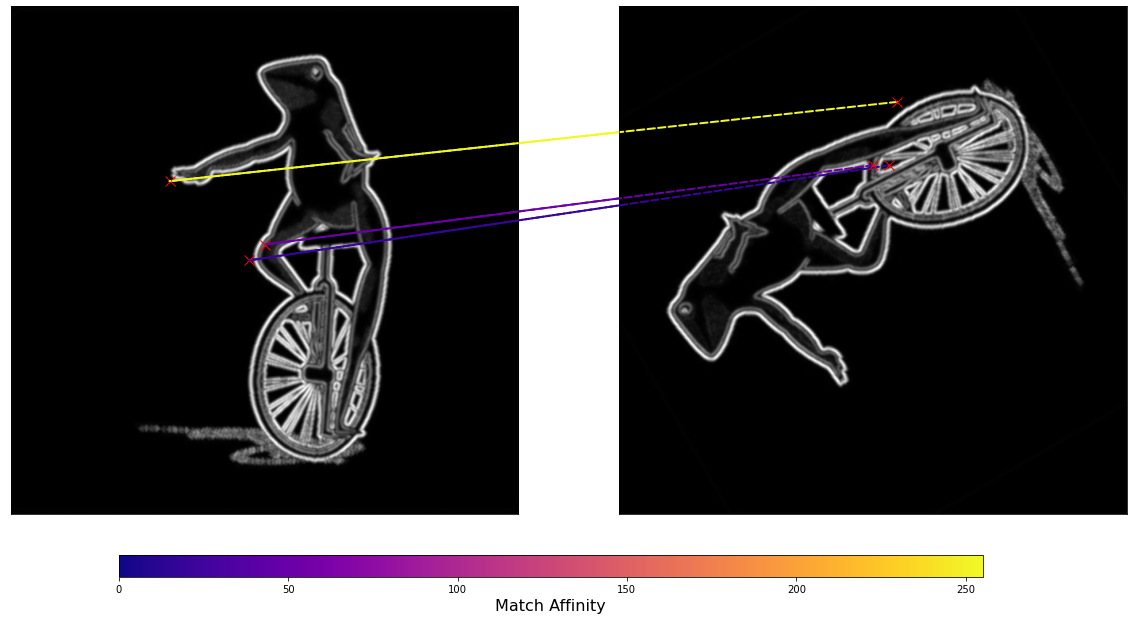

In [30]:
drawArrowsOnImages(initial_harris[:,:,0], rotated_harris[:,:,0], test_matches, 'gray', 'plasma', lw = 2.0, ls = '--')

## Finding Suitable Corners in an Image

The Harris corner image will be a masking tool to select points. Only corner points will be selected that have no previous corner points selected near them within a certain distance. There also need to be n-channel feature images to do the matching. The n-channel image is read into feature vectors for each corner detected. A matching method is then applied to calculated the simularity between each feature vector. 

The angle of Harris will be used to measure the angle change. Oriented windows could be used to find features but windows using euclidean distance (circular windows) works as well.

In [31]:
# export
@dataclass
class HarrisPoint: 
    feature_vector: np.array = np.array([], dtype = np.float32)
    coordinate: np.array = np.array([0,0], dtype = np.float32)
    magnitude: float = 0.
    angle:float = 0.
    corner_measure:float = 0.
    assignment: bool = False
    
    def __len__(self):
        return len(self.feature_vector)
    
    def __getitem__(self, idx):
        return self.feature_vector[idx]
    
    def distanceTo(self, i: int, j: int):
        distance = self.coordinate - (i, j)
        return np.dot(distance, distance)
    
    def normaliseHist(self):
        hist_norm = np.linalg.norm(self.feature_vector)
        if hist_norm > 0: self.feature_vector /= hist_norm
    
    def updateHistogram(self, n_hist_buckets, k: int, px: float):
        hist_index = int(n_hist_buckets * px)
        hist_index += k * n_hist_buckets
        self.feature_vector[hist_index] += 1
    
    def __str__(self):
        if len(self) < 11:
            out_str = 'Hp : ' + str(self.coordinate) + '|' + str([np.round(feat, 3) for feat in self.feature_vector[:10]])
            out_str = out_str[:-1] + ', ... ]'
            return out_str
        else:
            return 'Hp : ' + str(self.coordinate) + '|' + str([np.round(feat, 3) for feat in self.feature_vector[:10]])

In [32]:
test_harris = HarrisPoint(
    np.array([1,2,3,4], dtype = np.float32), 
    np.array([0,0], dtype = np.float32),
    0, 0, 0
)

In [33]:
assert(test_harris.distanceTo(2,2) == 8.)

In [34]:
# export
class HarrisPointArray:
    def __init__(self, feature_len: int, distance_thresh: float):
        self.points = []
        self.template_array = np.ndarray(feature_len, dtype = np.float32)
        self.template_array.fill(0.)
        self.feature_len = feature_len
        self.distance_euclid = distance_thresh
        self.distance_thresh = distance_thresh ** 2
        
    def addPoint(self, i: int, j: int, mag: float, angle: float, corner: float):
        new_point = HarrisPoint(
            self.template_array.copy(),
            np.array([i, j], dtype = np.float32),
            mag, angle, corner
        )
        self.points.append(new_point)
        
    def checkAllDistances(self, i: int, j: int):
        for point in self:
            if point.distanceTo(i, j) < self.distance_thresh:
                return point
        return
    
    def getHistogramBuckets(self, channels: int):
        if self.feature_len % channels != 0:
            print('Warning: feature vector is not a mutiple of feature channels')
        return self.feature_len // channels
            
    def normaliseAllHistograms(self):
        for point in self: point.normaliseHist()

    def plotPoints(self, img: np.array, circ_color = 'w', **kwargs):
        plt.imshow(img, **kwargs)
        ax = plt.gca()
        for point in self:
            plt.scatter(*reversed(point.coordinate))
            circ = Circle(
                tuple(reversed(point.coordinate)), 
                radius = self.distance_euclid,
                fill = False, 
                color = circ_color
            )
            ax.add_patch(circ)
    
    def deassignAllPoints(self):
        for point in self: point.assignment = False
    
    def __len__(self):
        return len(self.points)
    
    def __str__(self):
        n_iterations = 0
        output_str = 'Hp Arr -' + str(len(self)) + ' points -{\n'
        for point in self:
            output_str += str(point)
            output_str += '\n'
            n_iterations += 1
            if n_iterations > 10: 
                output_str += '... \n';break
        output_str += '}'
        return output_str
            
    def __iter__(self):
        for point in self.points:
            yield point

In [35]:
# export
def thresholdHarrisWithinDistance(harris_img: np.array, corner_thresh: float, distance_thresh: float, feature_len: int):
    _, _, width, channels, _ = getChannels(harris_img)
    if channels != 3 : print('Incorrect numer of input channels'); return
    harris_points = HarrisPointArray(feature_len, distance_thresh)

    i, j, k = 0, 0, 0
    for px in np.nditer(harris_img, order = 'C', op_flags = ['readwrite']):
        if k == 0:
            curr_x = px
        elif k == 1:
            curr_y = px
        else:
            if px > corner_thresh:
                if not harris_points.checkAllDistances(i, j):
                    harris_points.addPoint(i, j, curr_y, curr_x, px)
        i, j, k = iterateImage(i, j, k, 3, width)
    return harris_points

The function call below find corner points in the top 10% of matches and no two points should be close then 10 pixels. There is a fixed sized feature array declared for each Harris point.

In [36]:
harris_points = thresholdHarrisWithinDistance(harris_frog, 0.8, 20., 60)

In [37]:
print(harris_points)

Hp Arr -18 points -{
Hp : [178. 350.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [186. 461.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [206. 205.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [295. 364.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [305. 388.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [365. 353.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [372. 430.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [381. 370.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [404. 339.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [444. 373.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Hp : [447. 405.]|[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
... 
}


We can plot all the Harris points detected. There are a lot of them around the wheel and some other good ones around the seat.

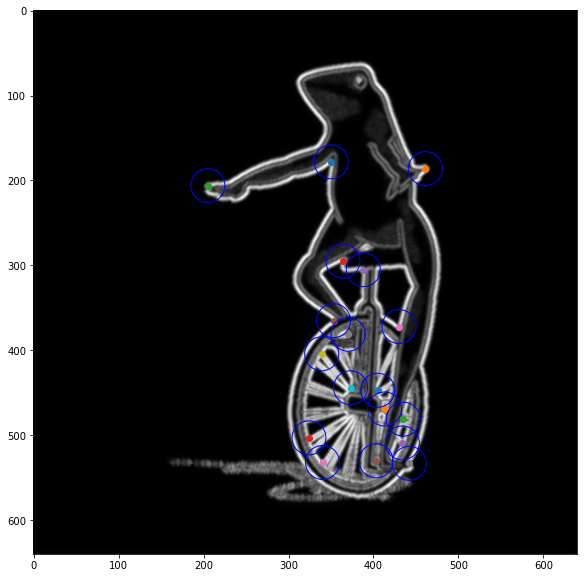

In [38]:
plt.figure(figsize=(10,10))
harris_points.plotPoints(harris_frog[:,:,0], circ_color = 'b', cmap = 'gray')

## Matching Similiarity of Feature Images

Feature images are used to create values to fill in a histogram. These feature images essentially are used to describe a Harris point to determine if it is similiar to another Harris point.

First two feature images will be created using the rotated an unrotated image. Each channel should be normalised before any comparisions are made. Rotationally invariant windows are used to make histograms which function as feature vectors. The feature vectors are then added to Harris Points.

The feature images that will be used is the derivative magnitude channel (which is already available from Harris Corner Detections) and the original greyscale channel. Additional channels can be added.

In [39]:
# export
def normaliseImage(img: np.array):
    img, _, _, channels, _ = getChannels(img)
    img = np.float32(img)
    for k in range(channels):
        min_img = np.min(np.array(img[:,:,k]))
        max_img = np.max(np.array(img[:,:,k])) - min_img + 0.001
        img[:,:,k] += min_img
        if max_img != 0:
            img[:,:,k] /= max_img
    return img

def createFeatureImage(*args):
    base_height = None
    base_width = None
    total_channels = 0
    channel_arr = []

    for img in args:
        _, height, width, channels, _ = getChannels(img)
        channel_arr += [channels]
        if not base_height: base_height = height
        elif base_height != height:
            print('Error! Not all input images have the same height.'); return
        if not base_width: base_width = width
        elif base_height != height:
            print('Error! Not all input images have the same height.'); return
        total_channels += channels

    feat_img = np.ndarray((base_height, base_width, total_channels), dtype = np.float32)
    current_channel = 0
    img_ind = 0
    for img in args:
        img = normaliseImage(img)
        next_channel = current_channel + channel_arr[img_ind]
        feat_img[:, :, current_channel:next_channel] = img
        current_channel = next_channel
        img_ind += 1
    return feat_img

In [40]:
frog_feat_image = createFeatureImage(harris_frog[:,:,0], harris_frog[:,:,2], grey_frog_img)

In [41]:
feat_image_shape = np.array([640, 640, 3])
assert(np.linalg.norm(feat_image_shape - frog_feat_image.shape) == 0)

In [42]:
# export
def getFeatureVectorsFromCornerPoints(harris_points: HarrisPointArray, feature_images: np.ndarray):
    _, _, width, channels, _ = getChannels(feature_images)
    n_hist_buckets = harris_points.getHistogramBuckets(channels)

    i, j, k = 0, 0, 0
    for px in np.nditer(feature_images, order = 'C', op_flags = ['readwrite']):
        if k == 0: matched_point = harris_points.checkAllDistances(i, j)
        if matched_point: matched_point.updateHistogram(n_hist_buckets, k, px)
        i, j, k = iterateImage(i, j, k, channels, width)
    harris_points.normaliseAllHistograms()
    return harris_points

In [43]:
harris_points = getFeatureVectorsFromCornerPoints(harris_points, frog_feat_image)

In [44]:
print(harris_points)

Hp Arr -18 points -{
Hp : [178. 350.]|[0.319, 0.137, 0.084, 0.046, 0.049, 0.058, 0.076, 0.06, 0.024, 0.019]
Hp : [186. 461.]|[0.48, 0.027, 0.017, 0.021, 0.016, 0.022, 0.032, 0.03, 0.019, 0.014]
Hp : [206. 205.]|[0.492, 0.018, 0.014, 0.02, 0.016, 0.039, 0.032, 0.01, 0.013, 0.018]
Hp : [295. 364.]|[0.291, 0.057, 0.17, 0.117, 0.039, 0.051, 0.082, 0.039, 0.018, 0.016]
Hp : [305. 388.]|[0.389, 0.029, 0.051, 0.042, 0.029, 0.044, 0.063, 0.067, 0.045, 0.022]
Hp : [365. 353.]|[0.186, 0.072, 0.099, 0.061, 0.047, 0.059, 0.09, 0.109, 0.088, 0.059]
Hp : [372. 430.]|[0.178, 0.163, 0.143, 0.054, 0.056, 0.056, 0.085, 0.073, 0.087, 0.048]
Hp : [381. 370.]|[0.001, 0.027, 0.055, 0.102, 0.19, 0.238, 0.178, 0.144, 0.082, 0.042]
Hp : [404. 339.]|[0.132, 0.065, 0.058, 0.05, 0.036, 0.045, 0.044, 0.084, 0.115, 0.108]
Hp : [444. 373.]|[0.142, 0.057, 0.033, 0.047, 0.094, 0.104, 0.153, 0.138, 0.143, 0.102]
Hp : [447. 405.]|[0.147, 0.065, 0.073, 0.073, 0.061, 0.076, 0.121, 0.139, 0.096, 0.055]
... 
}


In [45]:
rot_harris_points = thresholdHarrisWithinDistance(rotated_harris, 0.8, 20., 60)
rot_frog_feat_image = createFeatureImage(rotated_harris[:,:,0], rotated_harris[:,:,2], grey_rotated_frog)
assert(np.linalg.norm(feat_image_shape - rot_frog_feat_image.shape) == 0)
getFeatureVectorsFromCornerPoints(rot_harris_points, rot_frog_feat_image);

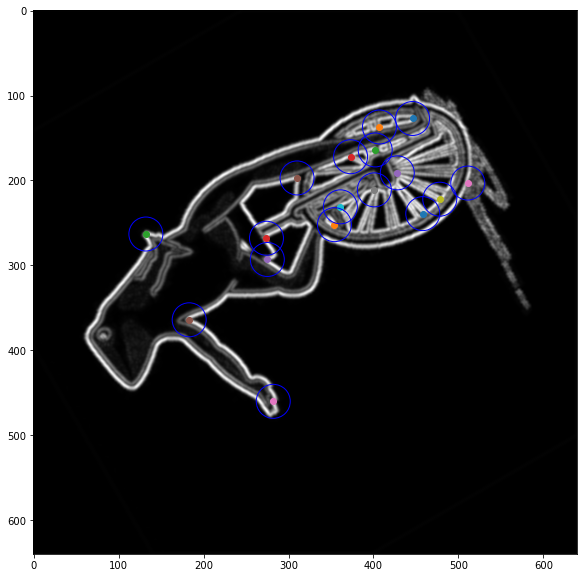

In [46]:
plt.figure(figsize=(10,10))
rot_harris_points.plotPoints(rotated_harris[:,:,0], circ_color = 'b', cmap = 'gray')

In [47]:
print(rot_harris_points)

Hp Arr -17 points -{
Hp : [127. 446.]|[0.008, 0.056, 0.052, 0.064, 0.093, 0.146, 0.221, 0.159, 0.103, 0.043]
Hp : [137. 407.]|[0.005, 0.121, 0.13, 0.061, 0.09, 0.129, 0.194, 0.141, 0.082, 0.073]
Hp : [164. 402.]|[0.18, 0.124, 0.069, 0.064, 0.043, 0.067, 0.091, 0.121, 0.12, 0.102]
Hp : [172. 373.]|[0.205, 0.121, 0.072, 0.058, 0.048, 0.063, 0.089, 0.098, 0.05, 0.082]
Hp : [191. 428.]|[0.211, 0.047, 0.027, 0.029, 0.031, 0.047, 0.048, 0.07, 0.082, 0.121]
Hp : [197. 310.]|[0.167, 0.225, 0.062, 0.05, 0.069, 0.08, 0.092, 0.102, 0.05, 0.029]
Hp : [203. 511.]|[0.02, 0.071, 0.062, 0.056, 0.12, 0.221, 0.254, 0.169, 0.131, 0.07]
Hp : [211. 401.]|[0.064, 0.055, 0.052, 0.068, 0.087, 0.084, 0.136, 0.116, 0.155, 0.145]
Hp : [222. 478.]|[0.181, 0.071, 0.037, 0.046, 0.042, 0.032, 0.034, 0.075, 0.125, 0.093]
Hp : [231. 361.]|[0.0, 0.01, 0.044, 0.058, 0.084, 0.143, 0.116, 0.118, 0.141, 0.16]
Hp : [239. 458.]|[0.145, 0.068, 0.05, 0.038, 0.039, 0.061, 0.053, 0.08, 0.08, 0.074]
... 
}


## Using the Matches to Estimate Rotation

In [48]:
# export
def dotProductSimiliarity(point1, point2):
    return 255 * np.dot(point1.feature_vector, point2.feature_vector)

In [49]:
# export
def findBestHarrisMatches(harris_points: HarrisPointArray, harris_points_other: HarrisPointArray, 
                          min_match_ratio: float, kernelFunction, min_matches: int):
    output_matches = []
    harris_points.deassignAllPoints()
    harris_points_other.deassignAllPoints()
    for point in harris_points:
        best_match = 0; best_point = None
        second_best_match = 0
        n_matches = 0
        for other_point in harris_points_other:
            if not point.assignment and not other_point.assignment:
                similiarity = kernelFunction(point, other_point)
                n_matches += 1
                if similiarity > best_match:
                    second_best_match = best_match
                    best_match = similiarity
                    best_point = other_point
                elif similiarity > second_best_match:
                    second_best_match = similiarity
        if best_match > 0 and second_best_match/best_match < min_match_ratio and n_matches > min_matches:
            best_point.assignment = True
            output_matches.append(
                HarrisMatch(tuple(reversed(point.coordinate)), 
                            tuple(reversed(best_point.coordinate)), 
                            best_match)
            )
    return output_matches

According to the SIFT methodology, there should be close to around 200 points to make a comparison. Here there is significantly less. Of the 200 points in each image, we take the best 20 matches and from that there should be a good statistical estimate of the changes that have occured. It is better having more points to make the estimate. You cannot rely on the best match. There is a stastical regularity with the estimates but there is error associated with every match - sometimes significant error.

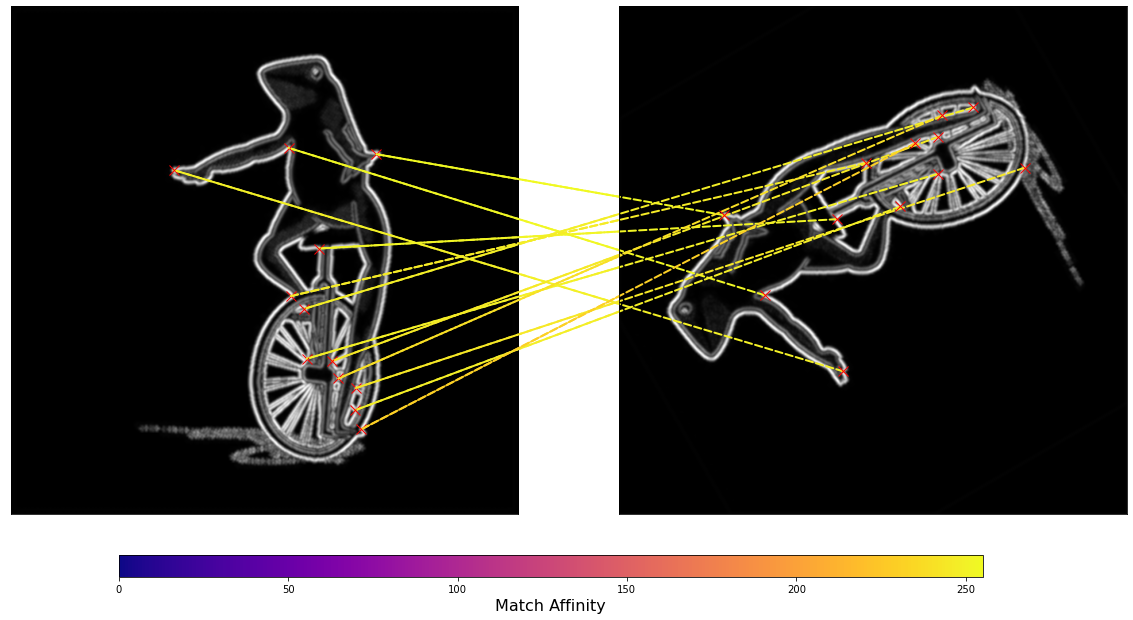

In [50]:
harris_matches = findBestHarrisMatches(harris_points, rot_harris_points, 0.99, dotProductSimiliarity, 2)
drawArrowsOnImages(initial_harris[:,:,0], rotated_harris[:,:,0], harris_matches, 'gray', 'plasma', lw = 2.0, ls = '--')

Since we know that the rotation was not accompanied by translation, we can removed points who distance from the center has changed too much. For the purposes of this example, the change in magnitude will not be used. A further check can be used to ensure that the Harris corner angle change is consistent with the actual angle change.

If there was a translation in addition to rotation, the matches can be all be used to take an average estimate of change in X and change in Y. For a particular object that has good background separation, we can observer there will be a center of gravity that can be used to estimate translation. The moments of the shape can also be used to estimate rotation for distrinctive shapes.

In [51]:
# export
def radianToDegrees(x):
    return x * 180 / np.pi

def getImageCenter(img):
    _, height, width, _, _ = getChannels(img)
    c_h = (height - 1)/2
    c_w = (width - 1)/2
    return np.array([c_h, c_w], dtype = np.float32)

def fitRotationalTransformation(harris_matches: list, center_point: np.array, distance_thresh: float):
    valid_estimates = []
    for match in harris_matches:
        coordA = center_point - match.coordinateA
        coordB = center_point - match.coordinateB
        normA = np.linalg.norm(coordA)
        normB = np.linalg.norm(coordB)
        norm_diff = np.abs(normA - normB)
        if norm_diff < distance_thresh:
            dot_prod = np.dot(coordA, coordB) / (normA * normB)
            angle = np.arccos(dot_prod)
            valid_estimates.append(radianToDegrees(angle))
    return np.median(valid_estimates)

In [52]:
image_center = getImageCenter(frog_img)
assert(np.linalg.norm(image_center - np.array([319.5, 319.5], dtype=np.float32)) < 1e-7)

In [53]:
estimated_rotation = fitRotationalTransformation(harris_matches, image_center, np.inf); print(estimated_rotation)

119.86538714095244


## Putting it all Together

The following function puts all estimation of rotation between two images into a single function for completeness.

In [54]:
# export
def getHarrisPoints(img: np.array, feat_img: np.array, 
                    derivative_size: int, blur_size: int, cornerFunction,
                    corner_threshold: float, harris_distance: float, feature_his_len: int):
    
    harris_img = harrisCornerImage(img, derivative_size, blur_size, cornerFunction)
    harris_points = thresholdHarrisWithinDistance(harris_img, corner_threshold, harris_distance, feature_his_len)
    harris_points = getFeatureVectorsFromCornerPoints(harris_points, feat_img)
    return harris_points

def estimateRotation(img: np.array, rot_img: np.array, feat_img: np.array, rot_feat_img: np.array,
                     derivative_size: int, blur_size: int, cornerFunction, corner_threshold: float,
                     harris_distance: float, feature_his_len: int,
                     min_match_ratio: float, kernelFunction, min_matches: int, norm_change_thresh: float):

    image_center = getImageCenter(img)
    image_center_rot = getImageCenter(rot_img)
    if np.linalg.norm(image_center - image_center_rot) > 1e-7:
        print('Error: Image centers not the same!'); return

    harris_points = getHarrisPoints(img, feat_img, derivative_size, blur_size, cornerFunction, corner_threshold, harris_distance, feature_his_len)
    rot_harris_points = getHarrisPoints(rot_img, rot_feat_img, derivative_size, blur_size, cornerFunction, corner_threshold, harris_distance, feature_his_len)
    harris_matches = findBestHarrisMatches(harris_points, rot_harris_points, min_match_ratio, kernelFunction, min_matches)
    rotation = fitRotationalTransformation(harris_matches, image_center, norm_change_thresh)
    return rotation

In [55]:
check_rotation = estimateRotation(grey_frog_img, grey_rotated_frog, frog_feat_image, rot_frog_feat_image,
                                  7, 5, determinantOverTrace, 0.8, 20., 60, 0.99, dotProductSimiliarity, 2, np.inf)

In [56]:
assert(np.abs(check_rotation - estimated_rotation) < 1e-7)

## Export

In [57]:
!python notebook2script.py HarrisCornerDetection.ipynb

Converted HarrisCornerDetection.ipynb to Export\nb_HarrisCornerDetection.py
